Project 2: Ames Housing Data and Kaggle Challenge

Problem Statement:
    To create a regression model to predict the sales price for each house

In [1]:
import random as rand
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn import feature_extraction 
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ames_train = pd.read_csv('datasets/train.csv')

In [3]:
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(ames_train)

(2051, 81)

    Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

In [4]:
#Replacing the np.nan cells to their respective column values

ames_train['Lot Frontage'] = ames_train['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_train['Alley'] = ames_train['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 22 entries that are tied to each other
ames_train['Mas Vnr Type'] = ames_train['Mas Vnr Type'].replace({np.nan:'None'})
ames_train['Mas Vnr Area'] = ames_train['Mas Vnr Area'].replace({np.nan:0})

#55 entries without basement
ames_train['Bsmt Qual'] = ames_train['Bsmt Qual'].replace({np.nan:'NA'})
ames_train['Bsmt Cond'] = ames_train['Bsmt Cond'].replace({np.nan:'NA'})

#These three cells has a basement but their exposure is unknown
ames_train.iloc[1456, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1547, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1997, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'

#entries without basement
ames_train['Bsmt Exposure'] = ames_train['Bsmt Exposure'].replace({np.nan:'NA'})
ames_train['BsmtFin Type 1'] = ames_train['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 1'] = ames_train['BsmtFin SF 1'].replace({np.nan:0})
ames_train['BsmtFin Type 2'] = ames_train['BsmtFin Type 2'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 2'] = ames_train['BsmtFin SF 2'].replace({np.nan:0})
ames_train['Bsmt Unf SF'] = ames_train['Bsmt Unf SF'].replace({np.nan:0})
ames_train['Total Bsmt SF'] = ames_train['Total Bsmt SF'].replace({np.nan:0})
ames_train['Bsmt Full Bath'] = ames_train['Bsmt Full Bath'].replace({np.nan:0})
ames_train['Bsmt Half Bath'] = ames_train['Bsmt Half Bath'].replace({np.nan:0})

#All fireplace Qu with np.nan is does not have a fireplace.
ames_train['Fireplace Qu'] = ames_train['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row1712, does not have a garage. 
ames_train['Garage Type'] = ames_train['Garage Type'].replace({np.nan:'NA'})
ames_train.iloc[1712, ames_train.columns.get_loc('Garage Yr Blt')] = ames_train.iloc[1712, ames_train.columns.get_loc('Year Remod/Add')]
ames_train['Garage Yr Blt'] = ames_train['Garage Yr Blt'].replace({np.nan:0})
ames_train['Garage Finish'] = ames_train['Garage Finish'].replace({np.nan:'NA'})
ames_train['Garage Cars'] = ames_train['Garage Cars'].replace({np.nan:0})
ames_train['Garage Area'] = ames_train['Garage Area'].replace({np.nan:0})
ames_train['Garage Qual'] = ames_train['Garage Qual'].replace({np.nan:'NA'})
ames_train['Garage Cond'] = ames_train['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_train['Pool QC'] = ames_train['Pool QC'].replace({np.nan:'NA'})
ames_train['Fence'] = ames_train['Fence'].replace({np.nan:'NA'})
ames_train['Misc Feature'] = ames_train['Misc Feature'].replace({np.nan:'NA'})

In [5]:
#encoding each ordinal categorical features, full glossary in readme
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


def transform(col):
    for i in col:
        le.fit(ames_train[i])
        list(le.classes_)
        ames_train[i] = le.transform(ames_train[i])

columns = ['Lot Shape',
           'Utilities',
           'Land Slope',
           'Exter Qual',
           'Exter Cond',
           'Bsmt Qual',
           'Bsmt Cond',
           'Bsmt Exposure',
           'BsmtFin Type 1',
           'BsmtFin Type 2',
           'Heating QC',
           'Electrical',
           'Kitchen Qual',
           'Functional',
           'Fireplace Qu',
           'Garage Finish',
           'Garage Qual',
           'Garage Cond',
           'Paved Drive',
           'Pool QC',
           'Fence']

transform(columns)

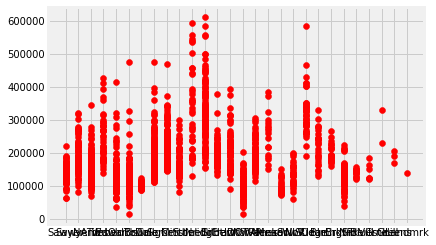

In [6]:
plt.scatter(ames_train['Neighborhood'],ames_train['SalePrice'],color='red')

In [7]:
column2= ['MS SubClass',
         'MS Zoning',
         'Street',
         'Alley',
         'Land Contour',
         'Lot Config',
         'Neighborhood',
         'Condition 1',
         'Condition 2',
         'Bldg Type',
         'House Style',
         'Roof Style',
         'Roof Matl',
         'Exterior 1st',
         'Exterior 2nd',
         'Mas Vnr Type',
         'Foundation',
         'Heating',
         'Central Air',
         'Garage Type',
         'Misc Feature',
         'Sale Type']

ames_train = pd.get_dummies(data = ames_train, prefix=column2, columns = column2, drop_first=True)

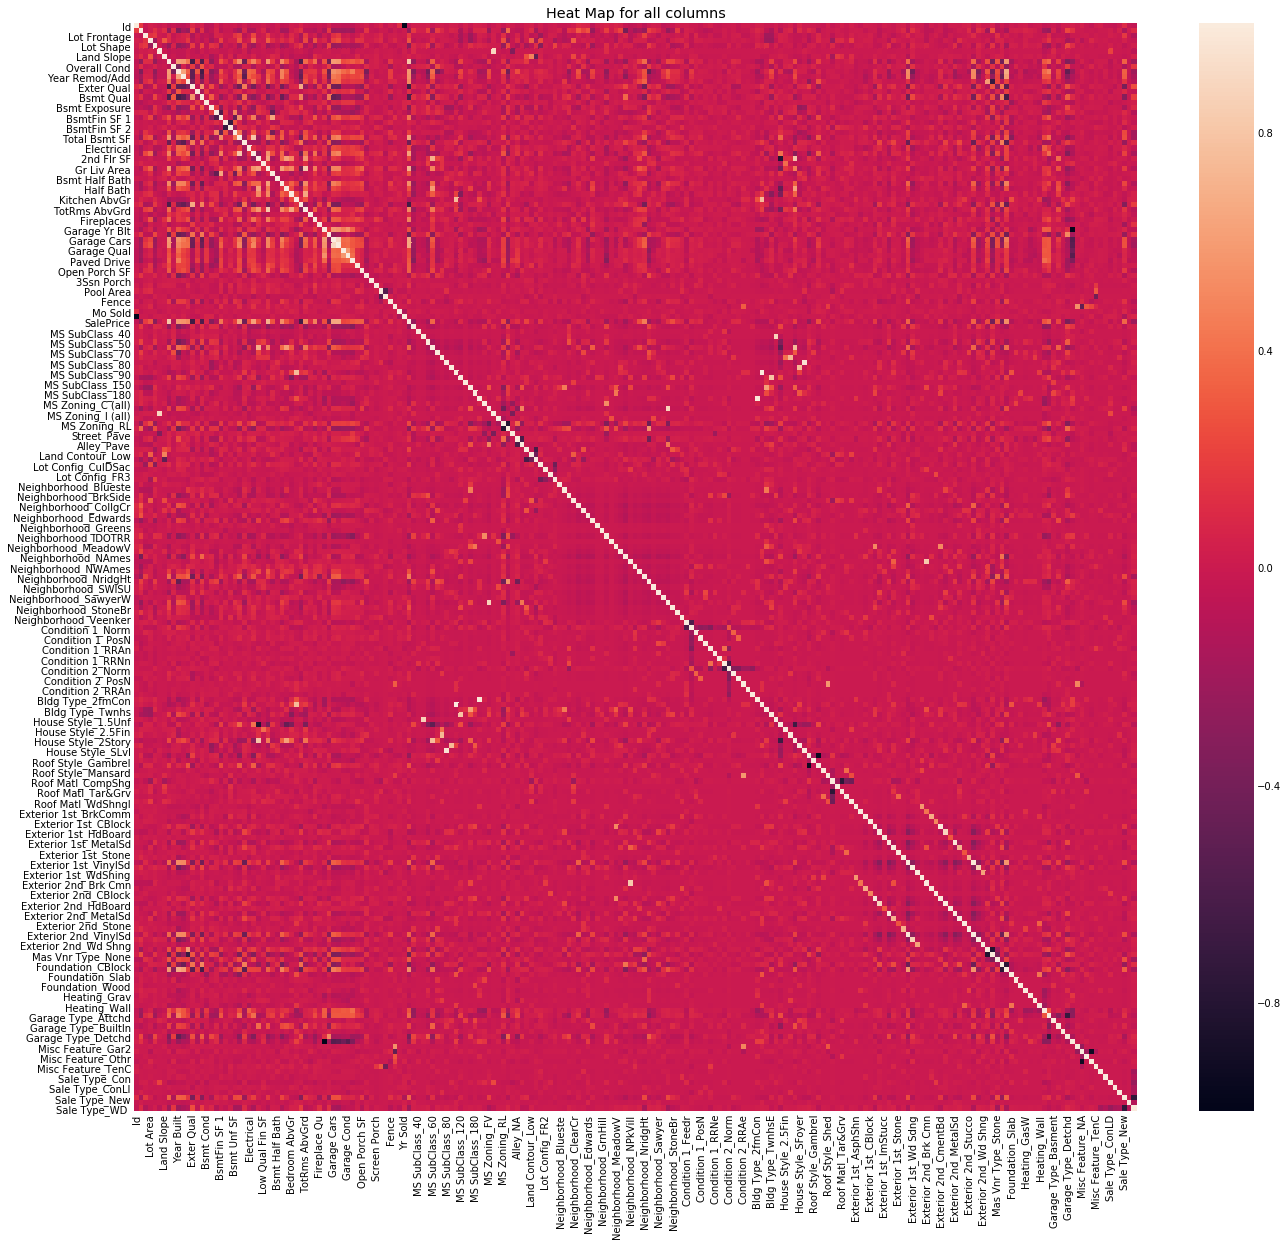

In [8]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(ames_train.corr(), ax = ax, annot=False, annot_kws={"size": 20})

In [9]:
ames_train[ames_train.columns[1:]].corr()['SalePrice'][:].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.800207
Gr Liv Area             0.697038
Garage Area             0.649897
Garage Cars             0.647781
Total Bsmt SF           0.629303
1st Flr SF              0.618486
Year Built              0.571849
Year Remod/Add          0.550370
Full Bath               0.537969
Foundation_PConc        0.529047
TotRms AbvGrd           0.504014
Mas Vnr Area            0.503579
Fireplaces              0.471093
Neighborhood_NridgHt    0.448647
BsmtFin SF 1            0.423856
Sale Type_New           0.358102
Garage Type_Attchd      0.357879
MS SubClass_60          0.355421
Exterior 1st_VinylSd    0.342146
Exterior 2nd_VinylSd    0.337563
Open Porch SF           0.333476
Wood Deck SF            0.326490
Mas Vnr Type_Stone      0.310026
Lot Area                0.296566
Paved Drive             0.290472
Bsmt Full Bath          0.283332
Half Bath               0.283001
Central Air_Y           0.277378
Roof Style_Hip          0.265224
Neighborho

In [10]:
def top_abs_corr(df, n):
    au_corr = df.corr().abs().unstack()
    au_corr = au_corr.sort_values(ascending=False).drop_duplicates()
    return au_corr[0:n]

print(top_abs_corr(ames_train, 20))

Sale Type_WD          Sale Type_WD            1.000000
Garage Yr Blt         Garage Type_NA          0.998504
Exterior 1st_CemntBd  Exterior 2nd_CmentBd    0.988379
Bldg Type_2fmCon      MS SubClass_190         0.977762
Exterior 2nd_VinylSd  Exterior 1st_VinylSd    0.977569
Exterior 2nd_MetalSd  Exterior 1st_MetalSd    0.976461
Yr Sold               Id                      0.975747
House Style_SLvl      MS SubClass_80          0.954552
Roof Style_Hip        Roof Style_Gable        0.948438
Misc Feature_NA       Misc Feature_Shed       0.926095
Utilities             MS Zoning_I (all)       0.894384
Garage Cars           Garage Area             0.893442
Exterior 1st_HdBoard  Exterior 2nd_HdBoard    0.885877
Neighborhood_Somerst  MS Zoning_FV            0.874854
MS SubClass_45        House Style_1.5Unf      0.869663
Exterior 1st_Wd Sdng  Exterior 2nd_Wd Sdng    0.859205
Mas Vnr Type_None     Mas Vnr Type_BrkFace    0.823329
Neighborhood_NPkVill  Exterior 2nd_Brk Cmn    0.822054
Gr Liv Are

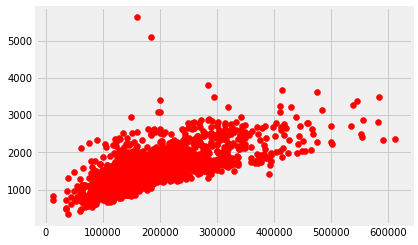

In [11]:
plt.scatter(ames_train['SalePrice'], ames_train['Gr Liv Area'],color='red')

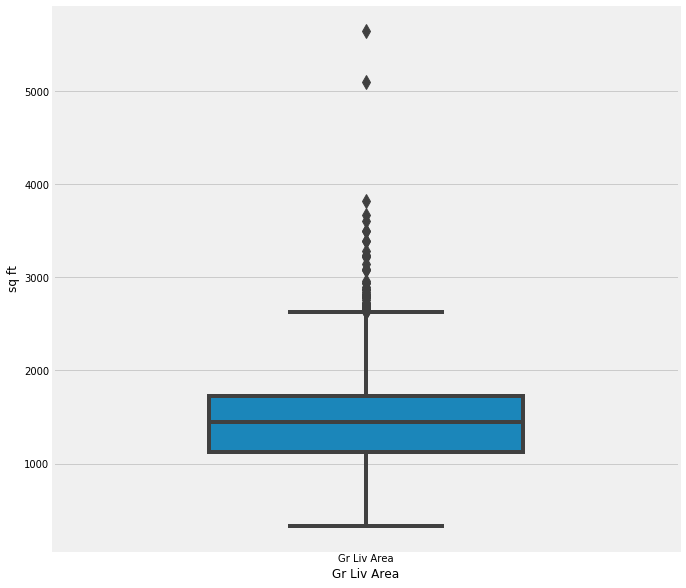

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(data = ames_train, order = ['Gr Liv Area'], 
                 orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='Gr Liv Area', ylabel='sq ft')

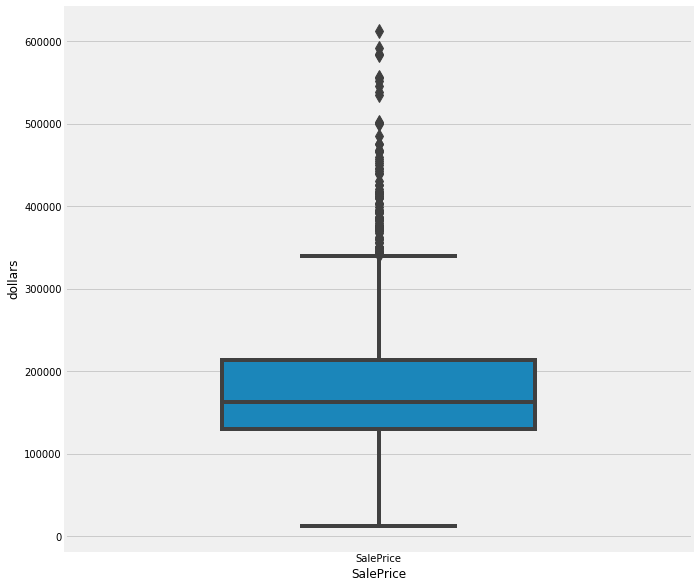

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(data = ames_train, order = ['SalePrice'], 
                 orient = 'v', width = 0.5, fliersize = 10).set(
    xlabel='SalePrice', ylabel='dollars')

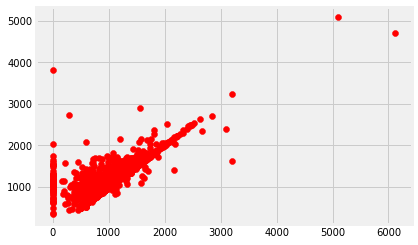

In [14]:
plt.scatter(ames_train['Total Bsmt SF'], ames_train['1st Flr SF'],color='red')

In [15]:
ames_train = ames_train.drop(['Id','PID'], axis=1)

In [16]:
ss = StandardScaler()

In [17]:
#Split df so that dummy variables are not standardized
ames1=ames_train.iloc[:,0:56]
ames2=ames_train.iloc[:,57:]

In [18]:
#Standarizing all other columns
ames1s = ss.fit_transform(ames1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
#convert them back to DataFrames
ames1s=pd.DataFrame(ames1s, columns = ames_train.iloc[:,0:56].columns)
ames2=pd.DataFrame(ames2, columns = ames_train.iloc[:,57:].columns)

In [20]:
#combine them back
ames_train_s = pd.concat([ames1s,ames2], axis=1,sort=False)

In [21]:
X = ames_train_s
y = ames_train.SalePrice

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model = linreg.fit(X_train,y_train)
linreg_scores = cross_val_score(model, X, y, cv=10)

print (linreg_scores)
print (np.mean(linreg_scores))

[ 6.95385002e-01 -1.68188275e+20 -2.66864068e+26 -5.78237124e+17
 -2.50953614e+21 -7.27463608e+20  8.73197478e-01 -3.37327764e+21
  8.92552416e-01 -2.43802932e+19]
-2.66870871541242e+25


In [23]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

81.48225310012857


In [24]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly worst off than baseline

[0.87129899 0.84326859 0.89520392 0.92106027 0.61575354 0.89031759
 0.91495204 0.89776841 0.87716183 0.72764655]
0.8454431725524229


In [25]:
lasso.fit(X_train, y_train)

Lasso(alpha=81.48225310012857, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

variable          coef      abs_coef
197     Misc Feature_Gar2  59853.669372  59853.669372
96   Neighborhood_GrnHill  56907.199714  56907.199714
111  Neighborhood_StoneBr  42825.773607  42825.773607
105  Neighborhood_NridgHt  36606.268328  36606.268328
80       Land Contour_HLS  24824.471204  24824.471204
117      Condition 1_PosN  23555.954789  23555.954789
104  Neighborhood_NoRidge  23533.109135  23533.109135
26            Gr Liv Area  18319.776579  18319.776579
132      Bldg Type_TwnhsE -15391.170646  15391.170646
131       Bldg Type_Twnhs -15110.074927  15110.074927
5            Overall Qual  15006.223144  15006.223144
160   Exterior 1st_Stucco -14030.449658  14030.449658
152  Exterior 1st_BrkFace  13697.990883  13697.990883
192   Garage Type_Basment -12260.806420  12260.806420
203         Sale Type_Con  10768.778779  10768.778779
82       Land Contour_Lvl  10663.646108  10663.646108
66        MS SubClass_120 -10647.562257  10647.562257
93   Neighborhood_Edwards  -8813.316562   8813.316562
40            Garage Cars   8678.063565   8678.063565
149     Roof Matl_WdShngl   8568.907209   8568.907209

In [27]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(210, 3)
96
Percent variables zeroed out: 0.45714285714285713


In [28]:
lasso_coefs2 = lasso_coefs[:(210-96)]
lasso_coefs2 = lasso_coefs2.drop(['coef','abs_coef'], axis=1)
lasso_coefs2

variable
197     Misc Feature_Gar2
96   Neighborhood_GrnHill
111  Neighborhood_StoneBr
105  Neighborhood_NridgHt
80       Land Contour_HLS
117      Condition 1_PosN
104  Neighborhood_NoRidge
26            Gr Liv Area
132      Bldg Type_TwnhsE
131       Bldg Type_Twnhs
5            Overall Qual
160   Exterior 1st_Stucco
152  Exterior 1st_BrkFace
192   Garage Type_Basment
203         Sale Type_Con
82       Land Contour_Lvl
66        MS SubClass_120
93   Neighborhood_Edwards
40            Garage Cars
149     Roof Matl_WdShngl
134    House Style_1Story
116      Condition 1_PosA
33           Kitchen Qual
92   Neighborhood_Crawfor
83     Lot Config_CulDSac
53               Misc Val
207         Sale Type_New
154  Exterior 1st_CemntBd
145     Roof Matl_CompShg
143    Roof Style_Mansard
106  Neighborhood_OldTown
115      Condition 1_Norm
137    House Style_2Story
6            Overall Cond
110  Neighborhood_Somerst
198       Misc Feature_NA
72           MS Zoning_FV
10             Exter Qual
103   Neighborhood_NWAmes
155  Exterior 1st_HdBoard
123      Condition 2_Norm
36             Fireplaces
14          Bsmt Exposure
27         Bsmt Full Bath
49           Screen Porch
174   Exterior 2nd_Stucco
190         Central Air_Y
97    Neighborhood_IDOTRR
7              Year Built
9            Mas Vnr Area
32          Kitchen AbvGr
59         MS SubClass_50
139      House Style_SLvl
16           BsmtFin SF 1
70        MS SubClass_190
182      Foundation_PConc
34          TotRms AbvGrd
94   Neighborhood_Gilbert
50              Pool Area
42            Garage Qual
162  Exterior 1st_Wd Sdng
29              Full Bath
209         Sale Type_WD 
114     Condition 1_Feedr
35             Functional
1                Lot Area
74           MS Zoning_RH
181     Foundation_CBlock
142        Roof Style_Hip
193   Garage Type_BuiltIn
12              Bsmt Qual
44            Paved Drive
3               Utilities
39          Garage Finish
30              Half Bath
4              Land Slope
76           MS Zoning_RM
86      Lot Config_Inside
101    Neighborhood_NAmes
15         BsmtFin Type 1
45           Wood Deck SF
38          Garage Yr Blt
21             Heating QC
8          Year Remod/Add
52                  Fence
13              Bsmt Cond
31          Bedroom AbvGr
161  Exterior 1st_VinylSd
23             1st Flr SF
46          Open Porch SF
0            Lot Frontage
118      Condition 1_RRAe
81       Land Contour_Low
22             Electrical
61         MS SubClass_70
51                Pool QC
179     Mas Vnr Type_None
140      Roof Style_Gable
55                Yr Sold
41            Garage Area
25        Low Qual Fin SF
47         Enclosed Porch
11             Exter Cond
54                Mo Sold
180    Mas Vnr Type_Stone
109  Neighborhood_SawyerW
177  Exterior 2nd_Wd Shng
90   Neighborhood_ClearCr
17         BsmtFin Type 2
48             3Ssn Porch
20          Total Bsmt SF
18           BsmtFin SF 2
2               Lot Shape
169  Exterior 2nd_HdBoard

In [29]:
#drop ['Misc Feature_Gar2', 'Neighborhood_GrnHill', 'Roof Matl_CompShg'] because
#they are not in the final test csv

X2 = X[[
"Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"Land Contour_HLS",
"Condition 1_PosN",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Bldg Type_TwnhsE",
"Bldg Type_Twnhs",
"Overall Qual",
"Exterior 1st_Stucco",
"Exterior 1st_BrkFace",
"Garage Type_Basment",
"Sale Type_Con",
"Land Contour_Lvl",
"MS SubClass_120",
"Neighborhood_Edwards",
"Garage Cars",
"Roof Matl_WdShngl",
"House Style_1Story",
"Condition 1_PosA",
"Kitchen Qual",
"Neighborhood_Crawfor",
"Lot Config_CulDSac",
"Misc Val",
"Sale Type_New",
"Exterior 1st_CemntBd",
"Roof Style_Mansard",
"Neighborhood_OldTown",
"Condition 1_Norm",
"House Style_2Story",
"Overall Cond",
"Neighborhood_Somerst",
"Misc Feature_NA",
"MS Zoning_FV",
"Exter Qual",
"Neighborhood_NWAmes",
"Exterior 1st_HdBoard",
"Condition 2_Norm",
"Fireplaces",
"Bsmt Exposure",
"Bsmt Full Bath",
"Screen Porch",
"Exterior 2nd_Stucco",
"Central Air_Y",
"Neighborhood_IDOTRR",
"Year Built",
"Mas Vnr Area",
"Kitchen AbvGr",
"MS SubClass_50",
"House Style_SLvl",
"BsmtFin SF 1",
"MS SubClass_190",
"Foundation_PConc",
"TotRms AbvGrd",
"Neighborhood_Gilbert",
"Pool Area",
"Garage Qual",
"Exterior 1st_Wd Sdng",
"Full Bath",
"Condition 1_Feedr",
"Functional",
"Lot Area",
"MS Zoning_RH",
"Foundation_CBlock",
"Roof Style_Hip",
"Garage Type_BuiltIn",
"Bsmt Qual",
"Paved Drive",
"Utilities",
"Garage Finish",
"Half Bath",
"Land Slope",
"MS Zoning_RM",
"Lot Config_Inside",
"Neighborhood_NAmes",
"BsmtFin Type 1",
"Wood Deck SF",
"Garage Yr Blt",
"Heating QC",
"Year Remod/Add",
"Fence",
"Bsmt Cond",
"Bedroom AbvGr",
"Exterior 1st_VinylSd",
"1st Flr SF",
"Open Porch SF",
"Lot Frontage",
"Condition 1_RRAe",
"Land Contour_Low",
"Electrical",
"MS SubClass_70",
"Pool QC",
"Mas Vnr Type_None",
"Roof Style_Gable",
"Yr Sold",
"Garage Area",
"Low Qual Fin SF",
"Enclosed Porch",
"Exter Cond",
"Mo Sold",
"Mas Vnr Type_Stone",
"Neighborhood_SawyerW",
"Exterior 2nd_Wd Shng",
"Neighborhood_ClearCr",
"BsmtFin Type 2",
"3Ssn Porch",
"Total Bsmt SF",
"BsmtFin SF 2",
"Lot Shape",
"Exterior 2nd_HdBoard"]]

In [30]:
X2
y = ames_train.SalePrice

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model2 = linreg.fit(X_train2,y_train2)
linreg_scores2 = cross_val_score(model2, X2, y, cv=10)

print (linreg_scores2)
print (np.mean(linreg_scores2))

[0.86509051 0.83245077 0.81405005 0.91901307 0.66960553 0.89900384
 0.90462929 0.90097936 0.88018224 0.73272243]
0.8417727102413253


In [31]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train2, y_train2)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.65401622935269


In [32]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly better than benchmark

[0.8699004  0.84074753 0.89603889 0.92361024 0.6174097  0.89134077
 0.9127894  0.89903138 0.87772278 0.72689371]
0.845548479596871


In [33]:
lasso_model = lasso.fit(X_train2, y_train2)
lasso_model

Lasso(alpha=62.65401622935269, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
lasso_coefs = pd.DataFrame({'variable':X_train2.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

variable          coef      abs_coef
0  Neighborhood_StoneBr  44367.372518  44367.372518
1  Neighborhood_NridgHt  38194.394074  38194.394074
2      Land Contour_HLS  26487.428209  26487.428209
3      Condition 1_PosN  25608.734075  25608.734075
4  Neighborhood_NoRidge  25417.223853  25417.223853

In [35]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(110, 3)
2
Percent variables zeroed out: 0.01818181818181818


In [36]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train2, y_train2)

print(optimal_ridge.alpha_)

1.2603829296797275


In [37]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.86941922 0.8444669  0.9046842  0.92623169 0.61129341 0.89492859
 0.90552965 0.90115882 0.87583411 0.71606172]
0.8449608317342909


In [38]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train2, y_train2)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)
#Full lasso model is preferred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.65401622935269
1.0


..................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.5s finished


In [39]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))
#same as lasso score

[0.8699004  0.84074753 0.89603889 0.92361024 0.6174097  0.89134077
 0.9127894  0.89903138 0.87772278 0.72689371]
0.845548479596871


In [40]:
lasso_model = lasso.fit(X_train2, y_train2)

In [41]:
lasso_model.score(X_train2, y_train2)

0.8947443063043361

In [42]:
lasso_model.score(X_test2, y_test2)

0.889984087965295

In [43]:
lasso_scores.mean()

0.845548479596871

In [44]:
y_pred = lasso_model.predict(X_test2)

In [45]:
r2_score(y_test2, y_pred)

0.889984087965295

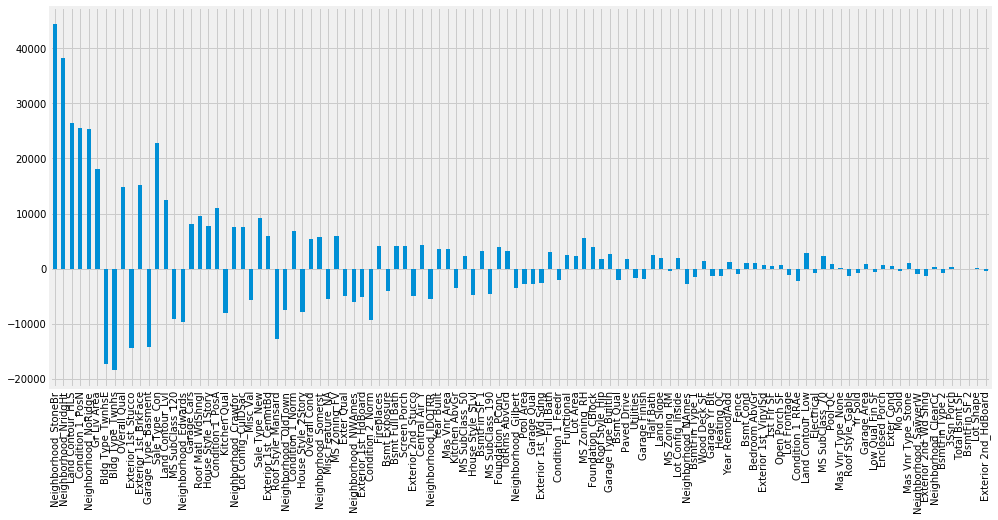

In [46]:
pd.Series(lasso.coef_, index=X2.columns).plot.bar(figsize=(15, 7))

In [47]:
residuals = y_test - y_pred

In [48]:
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)

print(lasso_mse)
print(lasso_rmse)

726774426.0961827
26958.754164393107


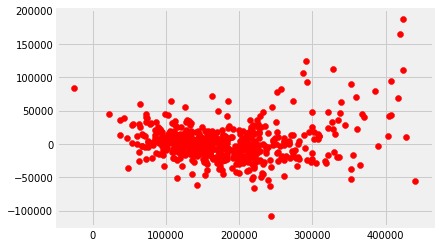

In [49]:
plt.scatter(y_pred, residuals,color='red')

In [50]:
ames_test = pd.read_csv('datasets/test.csv')

In [51]:
explore(ames_test)

(879, 80)

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1   NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   

  Condition 1 Condition 2 Bldg Type House Style  Overall 

In [52]:
ames_test.loc[(ames_test['Pool QC'].isin([np.nan]))]

Id         PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    2658   902301120          190        RM          69.0      9142   Pave   
1    2718   905108090           90        RL           NaN      9662   Pave   
2    2414   528218130           60        RL          58.0     17104   Pave   
3    1989   902207150           30        RM          60.0      8520   Pave   
4     625   535105100           20        RL           NaN      9500   Pave   
5     333   923228370          160        RM          21.0      1890   Pave   
6    1327   902427150           20        RM          52.0      8516   Pave   
7     858   907202130           20        RL           NaN      9286   Pave   
8      95   533208090          160        FV          39.0      3515   Pave   
9    1568   914476010           20        RL          75.0     10125   Pave   
10   2482   531452100          120        RL          50.0      7175   Pave   
11   1364   903455140           30        RM          60.0      7200   Pave   
12   2584   535303050           20        RL          75.0     11310   Pave   
13    818   906230030           90        RL           NaN      7976   Pave   
14   2673   903206160           70        RL          69.0     11737   Pave   
15   2089   905480180           20        RL          60.0      9060   Pave   
16   1297   902128150          190        RM          60.0     10800   Pave   
17    790   905451300           20        RL          68.0      9571   Pave   
18   2616   535425040           20        RL          80.0     10800   Pave   
19    720   902330040           70        RM         121.0     17671   Pave   
20    222   905105070           20        RL           NaN      8246   Pave   
21    557   532354160           20        RL           NaN      8499   Pave   
22   1148   531451020          120        RL          50.0      8012   Pave   
23   2766   906475050           80        RL           NaN     21453   Pave   
24    534   531363010           20        RL          80.0      9605   Pave   
25   1452   907227050           20        RL          60.0      7180   Pave   
26    630   535150070           50        RL           NaN     12513   Pave   
27   2648   902125020           70        RM          50.0      9000   Pave   
28    125   534425310           85        RL          80.0      8800   Pave   
29   1904   534451020           50        RL          51.0      3500   Pave   
30   1670   527404150           20        RL           NaN      7340   Pave   
31    756   903458170           30        RM          52.0      6240   Pave   
32    717   902326030           70        RM          65.0     11700   Pave   
33   1032   527378020           20        RL          80.0     10000   Pave   
34    852   907196060           20        RL          75.0     11166   Pave   
35   1731   528218100           60        RL          58.0     13204   Pave   
36   2639   902103090           50        RM          60.0      5520   Pave   
37   2071   905228020           20        RL           NaN      9000   Pave   
38   1267   535451010           20        RL          74.0      8892   Pave   
39   1851   533242080           20        FV          73.0      7321   Pave   
40    567   533210010          160        FV          40.0      3951   Pave   
41   2439   528280100           60        RL           NaN     11214   Pave   
42   1898   534427140           20        RL          75.0      7388   Pave   
43    647   535351050           20        RL          75.0     14559   Pave   
44   2256   916226090          120        RL          46.0      4054   Pave   
45    979   923228150          160        RM          21.0      1533   Pave   
46   1444   907196050           60        RL          68.0     11250   Pave   
47   2485   531479030           20        RH          60.0      7800   Pave   
48    157   535350040           20        RL          74.0      5868   Pave   
49     88   532377100           20        RL          75.

In [53]:
#Replacing the np.nan cells to their respective column values

#changing to 0 for no lot frontage, 160 entries
ames_test['Lot Frontage'] = ames_test['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_test['Alley'] = ames_test['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 1 entry that are tied to each other
ames_test['Mas Vnr Type'] = ames_test['Mas Vnr Type'].replace({np.nan:'None'})
ames_test['Mas Vnr Area'] = ames_test['Mas Vnr Area'].replace({np.nan:0})

#25 entries without basement
ames_test['Bsmt Qual'] = ames_test['Bsmt Qual'].replace({np.nan:'NA'})
ames_test['Bsmt Cond'] = ames_test['Bsmt Cond'].replace({np.nan:'NA'})
ames_test['Bsmt Exposure'] = ames_test['Bsmt Exposure'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 1'] = ames_test['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 2'] = ames_test['BsmtFin Type 2'].replace({np.nan:'NA'})

#1 electrical entry without additional information
ames_test.iloc[635, ames_test.columns.get_loc('Electrical')] = 'Mixed'

#All fireplace Qu with np.nan is does not have a fireplace,422 entries
ames_test['Fireplace Qu'] = ames_test['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row765, does not have a garage. 44 entries without garage
ames_test['Garage Type'] = ames_test['Garage Type'].replace({np.nan:'NA'})
ames_test.iloc[765, ames_test.columns.get_loc('Garage Yr Blt')] = ames_test.iloc[765, ames_test.columns.get_loc('Year Remod/Add')]
ames_test['Garage Yr Blt'] = ames_test['Garage Yr Blt'].replace({np.nan:0})
ames_test['Garage Finish'] = ames_test['Garage Finish'].replace({np.nan:'NA'})
ames_test['Garage Qual'] = ames_test['Garage Qual'].replace({np.nan:'NA'})
ames_test['Garage Cond'] = ames_test['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_test['Pool QC'] = ames_test['Pool QC'].replace({np.nan:'NA'})
ames_test['Fence'] = ames_test['Fence'].replace({np.nan:'NA'})
ames_test['Misc Feature'] = ames_test['Misc Feature'].replace({np.nan:'NA'})

In [54]:
def transform2(col):
    for i in col:
        le.fit(ames_test[i])
        list(le.classes_)
        ames_test[i] = le.transform(ames_test[i])

transform2(columns)

In [55]:
ames_test = pd.get_dummies(data = ames_test, prefix=column2, columns = column2, drop_first=True)

In [56]:
ames_test['Garage Yr Blt']=ames_test['Garage Yr Blt'].astype('float64')

In [57]:
ames1_test=ames_test.iloc[:,0:58]
ames2_test=ames_test.iloc[:,58:]

In [58]:
#Standarizing all other columns
ames1s_test = ss.fit_transform(ames1_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [59]:
#convert them back to DataFrames
ames1s_test=pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:58].columns)
ames2_test=pd.DataFrame(ames2_test, columns = ames_test.iloc[:,58:].columns)

In [60]:
#combine them back
ames_test_s = pd.concat([ames1s_test,ames2_test], axis=1,sort=False)

In [61]:
#drop ['Misc Feature_Gar2', 'Neighborhood_GrnHill', 'Roof Matl_CompShg'] because
#they are not in this test set
X_test_final = ames_test_s[[ 
"Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"Land Contour_HLS",
"Condition 1_PosN",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Bldg Type_TwnhsE",
"Bldg Type_Twnhs",
"Overall Qual",
"Exterior 1st_Stucco",
"Exterior 1st_BrkFace",
"Garage Type_Basment",
"Sale Type_Con",
"Land Contour_Lvl",
"MS SubClass_120",
"Neighborhood_Edwards",
"Garage Cars",
"Roof Matl_WdShngl",
"House Style_1Story",
"Condition 1_PosA",
"Kitchen Qual",
"Neighborhood_Crawfor",
"Lot Config_CulDSac",
"Misc Val",
"Sale Type_New",
"Exterior 1st_CemntBd",
"Roof Style_Mansard",
"Neighborhood_OldTown",
"Condition 1_Norm",
"House Style_2Story",
"Overall Cond",
"Neighborhood_Somerst",
"Misc Feature_NA",
"MS Zoning_FV",
"Exter Qual",
"Neighborhood_NWAmes",
"Exterior 1st_HdBoard",
"Condition 2_Norm",
"Fireplaces",
"Bsmt Exposure",
"Bsmt Full Bath",
"Screen Porch",
"Exterior 2nd_Stucco",
"Central Air_Y",
"Neighborhood_IDOTRR",
"Year Built",
"Mas Vnr Area",
"Kitchen AbvGr",
"MS SubClass_50",
"House Style_SLvl",
"BsmtFin SF 1",
"MS SubClass_190",
"Foundation_PConc",
"TotRms AbvGrd",
"Neighborhood_Gilbert",
"Pool Area",
"Garage Qual",
"Exterior 1st_Wd Sdng",
"Full Bath",
"Condition 1_Feedr",
"Functional",
"Lot Area",
"MS Zoning_RH",
"Foundation_CBlock",
"Roof Style_Hip",
"Garage Type_BuiltIn",
"Bsmt Qual",
"Paved Drive",
"Utilities",
"Garage Finish",
"Half Bath",
"Land Slope",
"MS Zoning_RM",
"Lot Config_Inside",
"Neighborhood_NAmes",
"BsmtFin Type 1",
"Wood Deck SF",
"Garage Yr Blt",
"Heating QC",
"Year Remod/Add",
"Fence",
"Bsmt Cond",
"Bedroom AbvGr",
"Exterior 1st_VinylSd",
"1st Flr SF",
"Open Porch SF",
"Lot Frontage",
"Condition 1_RRAe",
"Land Contour_Low",
"Electrical",
"MS SubClass_70",
"Pool QC",
"Mas Vnr Type_None",
"Roof Style_Gable",
"Yr Sold",
"Garage Area",
"Low Qual Fin SF",
"Enclosed Porch",
"Exter Cond",
"Mo Sold",
"Mas Vnr Type_Stone",
"Neighborhood_SawyerW",
"Exterior 2nd_Wd Shng",
"Neighborhood_ClearCr",
"BsmtFin Type 2",
"3Ssn Porch",
"Total Bsmt SF",
"BsmtFin SF 2",
"Lot Shape",
"Exterior 2nd_HdBoard"]]

In [62]:
y_pred_test = lasso_model.predict(X_test_final)

In [63]:
#y_pred_test
#ames_test
#ames1s_test = pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:58].columns)
y_pred_test=pd.DataFrame(y_pred_test, columns = ['SalePrice'])
final = pd.concat([ames_test.iloc[:,0],y_pred_test], axis=1)

In [64]:
final = final.sort_values(by=['Id'],ascending=True)
final

Id      SalePrice
704     2  114199.993605
706     4  277578.411147
120     6  188896.066281
312     7  247530.165276
401    17  195122.432334
316    18  349371.426467
791    22  201769.406639
608    27  117587.915565
391    31   83043.928723
753    36  139042.655527
317    39  389301.307852
324    40  274414.347193
710    42  340747.507258
453    46  244269.826176
168    53  174724.075802
620    58  182143.967720
201    61  316841.857384
643    72  242368.040359
469    79  110166.114976
441    80  211201.577464
393    82  172033.976813
479    83   80639.470550
587    85  158119.554780
49     88  117713.563145
794    92  292491.418418
345    93  283277.744470
8      95  179331.483467
636   102  196226.310355
648   103  188538.191212
346   106  245073.474192
340   107  169903.321419
590   110  233885.071181
108   114  193376.193938
141   116  191830.048495
686   117  155327.124200
830   118  148113.401994
28    125  162298.596063
814   126  167042.116743
142   127  146305.170694
667   128  205187.098677
708   134  129576.600355
134   135  158477.917826
847   137  230748.258789
267   143  130136.139955
740   147  121228.219390
516   148  197215.172134
477   150  128754.905489
676   156  144550.105237
48    157  136122.723677
222   159  118474.345613
356   161  276155.845575
651   167  149473.332942
233   170  123614.588058
257   171   70578.191448
856   175   81815.064195
93    179  142643.874117
744   181   93583.578346
51    186  207832.045787
188   193  179708.471646
448   194  100907.494074
599   206  115991.291543
117   208  130282.566182
795   210  147591.060080
363   211   93819.132970
497   212  107893.420962
804   214   81269.241916
407   215  133035.697106
110   217  145646.981964
20    222  169847.924706
133   227  138300.370620
813   228  174308.287830
843   233  239850.847460
511   235  134193.433606
290   238  127384.740179
609   241  166173.799637
395   252  188487.851840
534   253  191951.888429
541   256  147573.238961
574   257  143412.502503
747   258  188721.037679
344   259  181980.435483
148   261  145412.151683
87    263  138165.403313
408   266  236585.204643
762   267  225508.980869
578   270  152152.599680
700   271  259731.122777
528   276  119555.452269
743   285  137952.098671
634   288   25794.584620
323   289  161819.199780
225   290  141640.624452
315   291  152203.444483
181   292  106052.283899
632   293  196905.845246
136   294  222654.350493
631   295  177909.114449
82    304  137650.817221
245   322  308668.645404
571   326  161122.157406
678   327   83458.075225
192   328  129086.543567
232   331   90206.846492
157   332   71197.104387
5     333   78772.647731
389   335  133181.801347
869   337  155237.001944
247   342  107358.998466
111   343  184072.962095
767   347  179221.441718
629   350  324487.381511
857   352  248363.643027
745   358  200901.123632
473   359  181120.963109
770   360  159204.354019
872   368  334055.947076
693   369  290830.992152
727   373  181732.672580
413   377  248799.992967
742   383  220499.369964
112   386  228205.845035
456   387  236299.445647
58    390  156899.012669
185   391  154214.743018
55    395  171450.085927
74    397  144260.128311
275   398  122994.141517
419   401  103160.995106
863   404  104670.130560
724   408  118862.499692
326   409  121083.552541
558   410  141807.182210
531   418  104864.704782
238   422  430559.114869
86    427  343320.072120
426   431  394672.865187
164   433  449461.588769
71    437  364898.234980
404   438  294292.710622
383   442  349616.677453
798   447  252968.900816
302   459  320662.354197
165   460  279504.683275
842   464  212875.317033
808   465  184717.175025
501   467  181265.851772
224   468  195263.227752
831   474  166182.282072
434   480  206628.283786
187   481  211185.513897
379   483  230367.687604
249   488  165858.884026
650   492  174555.921565
803   494  174560.055488
416   499  323343.917346
230   500  278355.667621
65    501  328595.174928
298   503  266735.913784
286   506  248701.492386
751   5

In [65]:
final.to_csv("datasets/final2.csv", index=False) 